<a href="https://colab.research.google.com/github/Vanshsingh1203/vanshsingh.github.io/blob/main/Predicting_Temperature_Excursions_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'dict'>
dict_keys(['type', 'schemaVersion', 'creationDate', 'epcisHeader', 'epcisBody', '@context'])
Number of events: 5650
Flattened rows: (5809, 14)
event_time     datetime64[ns, UTC]
record_time    datetime64[ns, UTC]
dtype: object
event_type
ObjectEvent            5409
TransformationEvent     176
AggregationEvent        138
AssociationEvent         86
Name: count, dtype: int64
biz_step
receiving        2639
shipping         2570
commissioning     176
collecting        100
packing           100
Name: count, dtype: int64
list_type
quantityList          5409
childQuantityList      224
inputQuantityList       90
outputQuantityList      86
Name: count, dtype: int64

Event-level summary:
                        count unique  \
event_type               5809      4   
event_time_str           5809   5522   
event_timezone_offset    5809      1   
record_time_str          5809    155   
event_id                 5809   5650   
biz_step                 5809      8   
read_point_id     

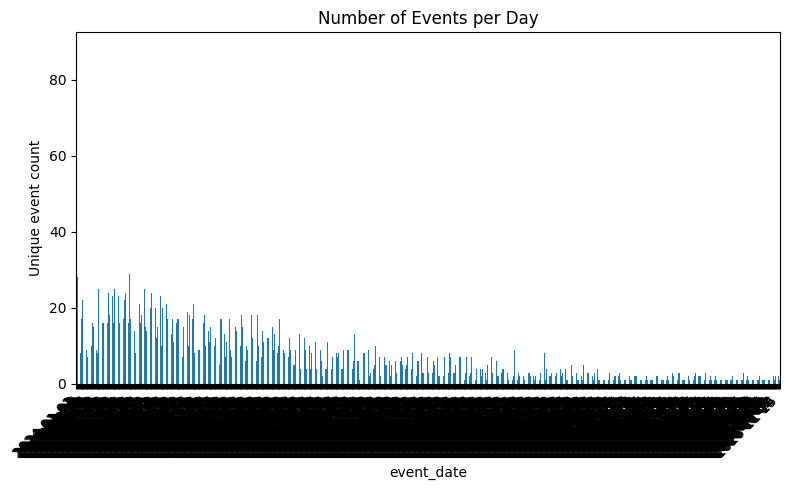

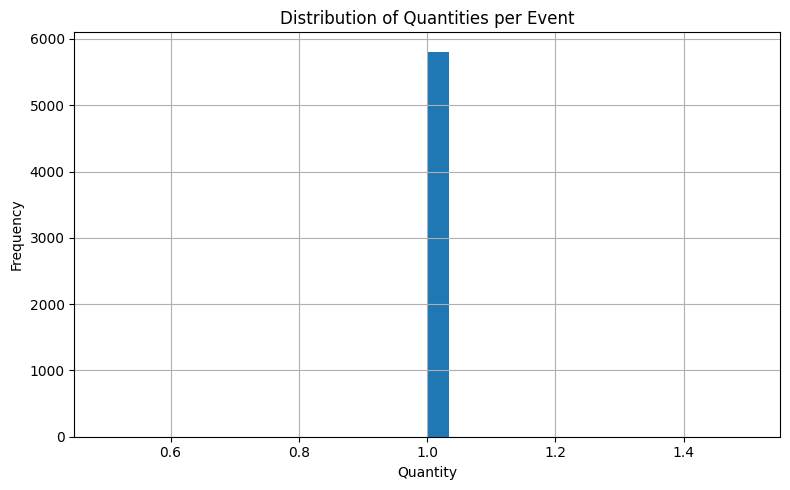

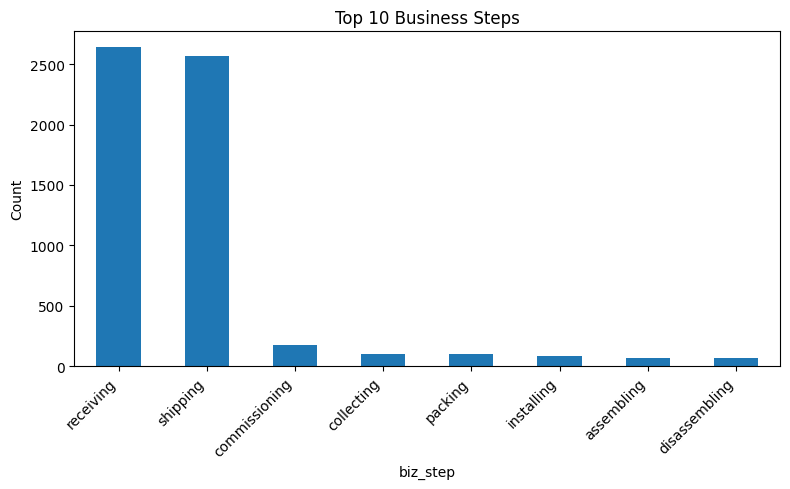

Chain-level DataFrame shape: (305, 7)
Chain-level features with biz step counts: (305, 19)


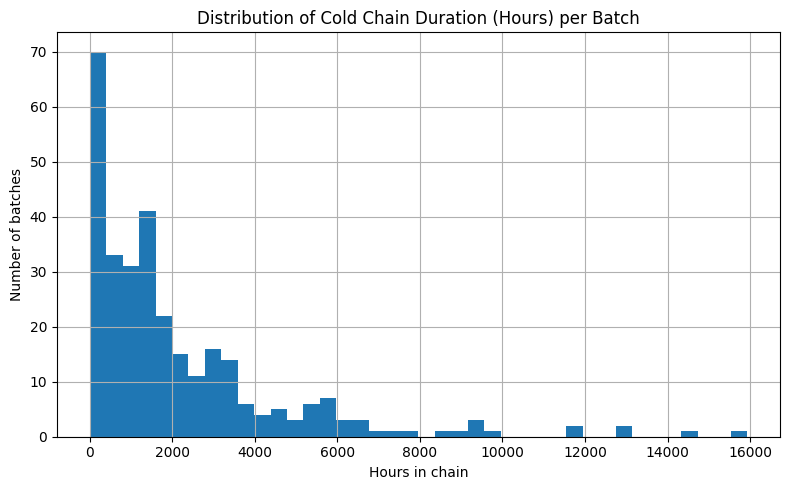

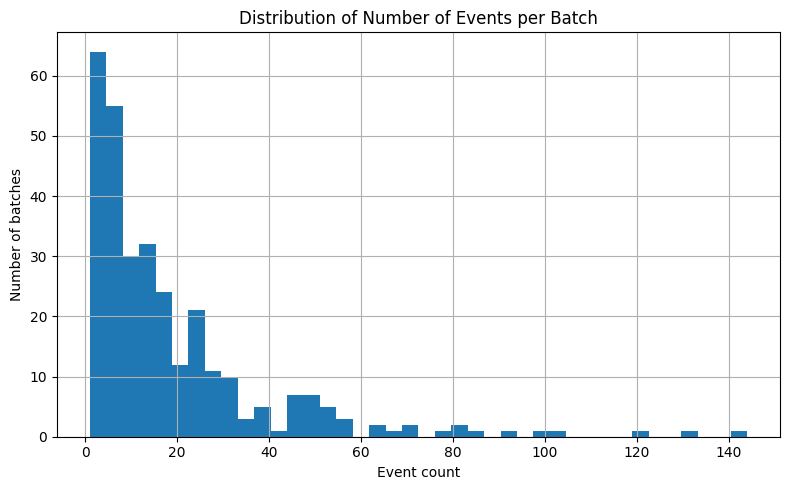

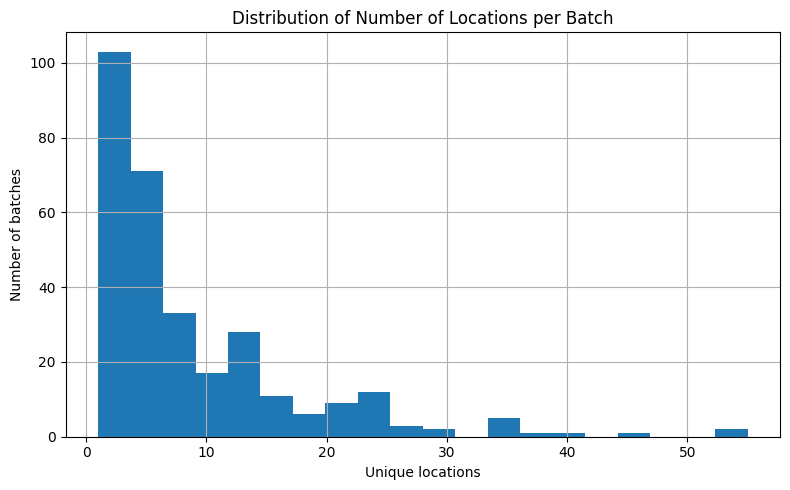


Summary of chain_duration_hours:
count      305.000000
mean      2151.123286
std       2544.761893
min          0.000000
25%        477.574167
50%       1313.603056
75%       2915.082222
max      15928.908333
Name: chain_duration_hours, dtype: float64
Top 2 origin locations: ['https://id.gs1.org/414/0012615136289/254/72415', 'https://id.gs1.org/414/0012797791177/254/41392']
n1 = 9 n2 = 8

Two-sample t-test: Origin A vs Origin B
t-statistic: 0.23879255945511813
p-value: 0.8145399007605989

One-way ANOVA across top 3 origins
F-statistic: 0.14612289831424252
p-value: 0.8649224088346378
75th percentile (hours): 2915.0822222222223
long_chain
0    229
1     76
Name: count, dtype: int64
Feature matrix shape: (305, 16)
Train size: (244, 16) Test size: (61, 16)

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        46
           1       0.93      0.93      0.93        15

    accuracy                          

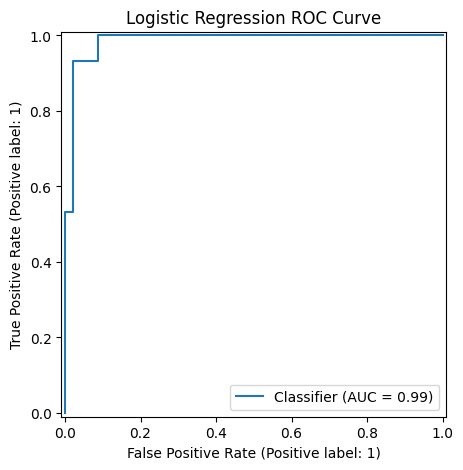


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        46
           1       0.81      0.87      0.84        15

    accuracy                           0.92        61
   macro avg       0.88      0.90      0.89        61
weighted avg       0.92      0.92      0.92        61

Confusion matrix:
 [[43  3]
 [ 2 13]]
ROC AUC: 0.9637681159420289


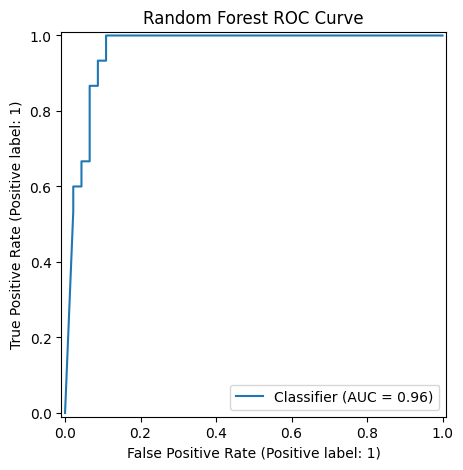

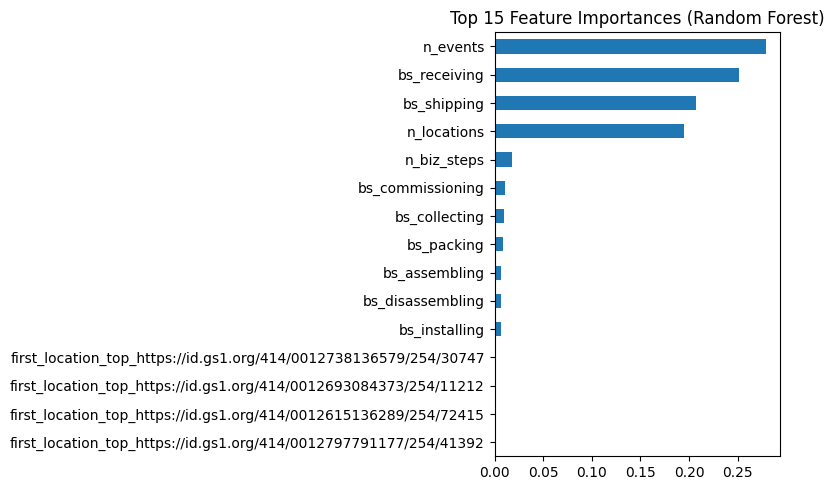

Saved chain-level feature data to cold_chain_batch_features.csv


In [9]:
# ============================================================
# 0. Setup & Imports
# ============================================================

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import ttest_ind, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

plt.rcParams["figure.figsize"] = (8, 5)

# ============================================================
# 1. Load EPCIS JSON file
# ============================================================

# In Google Colab:
# 1. Click the folder icon on the left.
# 2. Upload your file: synthetic-food-supply-chain-dataset.json
# 3. Make sure the filename below matches exactly.

FILE_PATH = "/content/synthetic-food-supply-chain-dataset.json"

with open(FILE_PATH, "r") as f:
    epcis_doc = json.load(f)

# Basic sanity check
print(type(epcis_doc))
print(epcis_doc.keys())

events = epcis_doc["epcisBody"]["eventList"]
print("Number of events:", len(events))

# ============================================================
# 2. Flatten EPCIS events to a tabular DataFrame
#    We create one row per (event, epcClass) in quantity lists
# ============================================================

rows = []

for ev in events:
    base = {
        "event_type": ev.get("type"),
        "event_time_str": ev.get("eventTime"),
        "event_timezone_offset": ev.get("eventTimeZoneOffset"),
        "record_time_str": ev.get("recordTime"),
        "event_id": ev.get("eventID"),
        "biz_step": ev.get("bizStep"),
        "read_point_id": ev.get("readPoint", {}).get("id"),
        "biz_location_id": ev.get("bizLocation", {}).get("id"),
    }

    # Extract only location-type sources/destinations
    source_locations = [
        s.get("source")
        for s in ev.get("sourceList", [])
        if s.get("type") == "location"
    ]
    dest_locations = [
        d.get("destination")
        for d in ev.get("destinationList", [])
        if d.get("type") == "location"
    ]

    base["source_locations"] = source_locations
    base["dest_locations"] = dest_locations

    # There can be several quantity lists; we treat each as separate rows
    for list_name in ["quantityList", "inputQuantityList", "outputQuantityList", "childQuantityList"]:
        q_list = ev.get(list_name, [])
        for q in q_list:
            row = base.copy()
            row["list_type"] = list_name
            row["epc_class"] = q.get("epcClass")
            row["quantity"] = q.get("quantity")
            row["uom"] = q.get("uom")
            rows.append(row)

df = pd.DataFrame(rows)
print("Flattened rows:", df.shape)
df.head()
# ============================================================
# 3. Basic cleaning & time parsing
# ============================================================

# Drop rows with no EPC class (defensive)
df = df.dropna(subset=["epc_class"]).reset_index(drop=True)

# Convert times to pandas datetime
df["event_time"] = pd.to_datetime(df["event_time_str"])
df["record_time"] = pd.to_datetime(df["record_time_str"])

# Basic sanity checks
print(df.dtypes[["event_time", "record_time"]])
print(df["event_type"].value_counts())
print(df["biz_step"].value_counts().head())
print(df["list_type"].value_counts())

# Some events might have missing quantities; that’s fine, we keep them
df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce")

# ============================================================
# 4. Simple EDA on event-level data
# ============================================================

print("\nEvent-level summary:")
print(df.describe(include="all").transpose())

# Events over time (by day)
df["event_date"] = df["event_time"].dt.date
events_per_day = df.groupby("event_date")["event_id"].nunique()

plt.figure()
events_per_day.plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.title("Number of Events per Day")
plt.ylabel("Unique event count")
plt.tight_layout()
plt.show()

# Distribution of quantities (if non-null)
plt.figure()
df["quantity"].dropna().hist(bins=30)
plt.title("Distribution of Quantities per Event")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Biz steps
plt.figure()
df["biz_step"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Business Steps")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
# ============================================================
# 5. Build "chain-level" features per epc_class
#    Think of epc_class as product+batch in the cold chain
# ============================================================

# Sort by time for consistency
df = df.sort_values(["epc_class", "event_time"]).reset_index(drop=True)

# Aggregate per epc_class: duration, count of events, locations, steps
agg = df.groupby("epc_class").agg(
    start_time=("event_time", "min"),
    end_time=("event_time", "max"),
    n_events=("event_time", "count"),
    n_locations=("biz_location_id", pd.Series.nunique),
    n_biz_steps=("biz_step", pd.Series.nunique)
).reset_index()

agg["chain_duration_hours"] = (agg["end_time"] - agg["start_time"]).dt.total_seconds() / 3600.0

print("Chain-level DataFrame shape:", agg.shape)
agg.head()
# ============================================================
# 6. Add first / last location, biz step counts as features
# ============================================================

# First and last location in time-order per epc_class
first_last = (
    df.sort_values(["epc_class", "event_time"])
      .groupby("epc_class")
      .agg(
          first_location=("biz_location_id", "first"),
          last_location=("biz_location_id", "last"),
          first_biz_step=("biz_step", "first"),
          last_biz_step=("biz_step", "last"),
      )
      .reset_index()
)

agg = agg.merge(first_last, on="epc_class", how="left")

# Biz step counts (wide format)
biz_step_dummies = pd.get_dummies(df[["epc_class", "biz_step"]], columns=["biz_step"], prefix="bs")
biz_step_counts = biz_step_dummies.groupby("epc_class").sum().reset_index()

agg = agg.merge(biz_step_counts, on="epc_class", how="left")

print("Chain-level features with biz step counts:", agg.shape)
agg.head()
# ============================================================
# 7. EDA on chain-level metrics
# ============================================================

plt.figure()
agg["chain_duration_hours"].hist(bins=40)
plt.title("Distribution of Cold Chain Duration (Hours) per Batch")
plt.xlabel("Hours in chain")
plt.ylabel("Number of batches")
plt.tight_layout()
plt.show()

plt.figure()
agg["n_events"].hist(bins=40)
plt.title("Distribution of Number of Events per Batch")
plt.xlabel("Event count")
plt.ylabel("Number of batches")
plt.tight_layout()
plt.show()

plt.figure()
agg["n_locations"].hist(bins=20)
plt.title("Distribution of Number of Locations per Batch")
plt.xlabel("Unique locations")
plt.ylabel("Number of batches")
plt.tight_layout()
plt.show()

print("\nSummary of chain_duration_hours:")
print(agg["chain_duration_hours"].describe())
# ============================================================
# 8. Hypothesis Testing example
#    H0: No difference in mean chain duration between top two origin locations.
# ============================================================

# Get top 2 most frequent first_locations
top_origins = (
    agg["first_location"]
    .value_counts()
    .dropna()
    .head(2)
    .index
    .tolist()
)

print("Top 2 origin locations:", top_origins)

group1 = agg[agg["first_location"] == top_origins[0]]["chain_duration_hours"].dropna()
group2 = agg[agg["first_location"] == top_origins[1]]["chain_duration_hours"].dropna()

print("n1 =", len(group1), "n2 =", len(group2))

tt_stat, p_val = ttest_ind(group1, group2, equal_var=False)
print("\nTwo-sample t-test: Origin A vs Origin B")
print("t-statistic:", tt_stat)
print("p-value:", p_val)

# If you want ANOVA across top 3 origins:
top3_origins = (
    agg["first_location"]
    .value_counts()
    .dropna()
    .head(3)
    .index
    .tolist()
)

anova_groups = [
    agg[agg["first_location"] == loc]["chain_duration_hours"].dropna()
    for loc in top3_origins
]

F_stat, p_anova = f_oneway(*anova_groups)
print("\nOne-way ANOVA across top 3 origins")
print("F-statistic:", F_stat)
print("p-value:", p_anova)
# ============================================================
# 9. Define target: "Long chain" batches (top 25% duration)
# ============================================================

q75 = agg["chain_duration_hours"].quantile(0.75)
agg["long_chain"] = (agg["chain_duration_hours"] > q75).astype(int)

print("75th percentile (hours):", q75)
print(agg["long_chain"].value_counts())

# ============================================================
# 10. Prepare features for ML model
# ============================================================

# We'll use:
# - chain_duration_hours is NOT a feature (it's the thing we're trying to anticipate),
#   but for one model you could pretend you only know early events; here we model long_chain
#   from: n_events, n_locations, biz step counts, first_location (top-k dummies).

features = agg.copy()

# Keep useful numeric columns
num_cols = ["n_events", "n_locations", "n_biz_steps"]
bs_cols = [c for c in features.columns if c.startswith("bs_")]

num_cols += bs_cols

# Categorical: first_location (only top K to avoid crazy dimensionality)
top_k = 5
top_first_locs = features["first_location"].value_counts().head(top_k).index.tolist()

features["first_location_top"] = features["first_location"].where(
    features["first_location"].isin(top_first_locs),
    other="OTHER"
)

X_cat = pd.get_dummies(features[["first_location_top"]], drop_first=True)
X_num = features[num_cols].fillna(0)

X = pd.concat([X_num, X_cat], axis=1)
y = features["long_chain"]

print("Feature matrix shape:", X.shape)
X.head()
# ============================================================
# 11. Train-test split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
# ============================================================
# 12. Logistic Regression model
# ============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Logistic Regression ROC Curve")
plt.show()
# ============================================================
# 13. Random Forest model
# ============================================================

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest ROC Curve")
plt.show()

# Feature importance plot
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure()
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()
# ============================================================
# 14. Save cleaned / engineered data for report & appendix
# ============================================================

agg.to_csv("cold_chain_batch_features.csv", index=False)
print("Saved chain-level feature data to cold_chain_batch_features.csv")


Number of events in EPCIS file: 5650
Flattened df shape: (5809, 12)


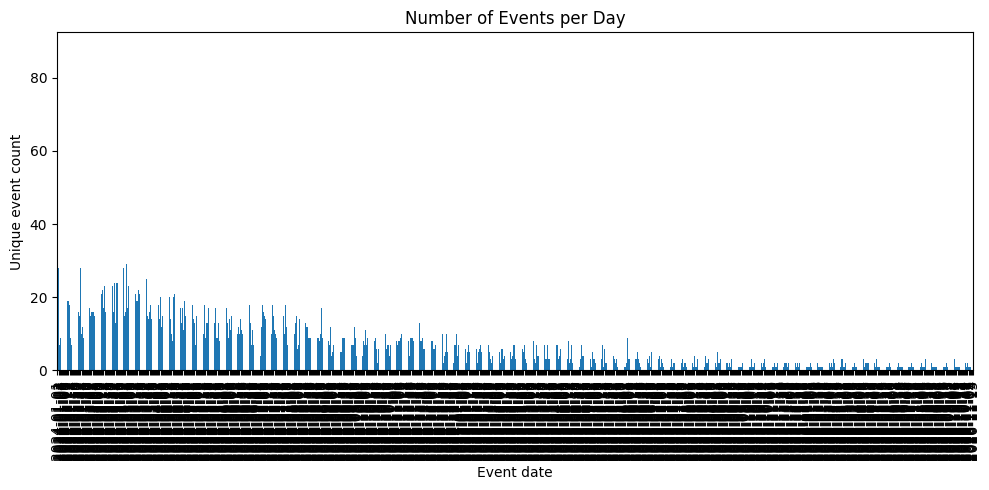

In [11]:
# ===== Cell 1: Setup, load JSON, flatten to df =====

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

plt.rcParams["figure.figsize"] = (8, 5)

# Path to your uploaded JSON file
FILE_PATH = "synthetic-food-supply-chain-dataset.json"

with open(FILE_PATH, "r") as f:
    epcis_doc = json.load(f)

events = epcis_doc["epcisBody"]["eventList"]
print("Number of events in EPCIS file:", len(events))

rows = []
for ev in events:
    base = {
        "event_type": ev.get("type"),
        "event_time_str": ev.get("eventTime"),
        "event_timezone_offset": ev.get("eventTimeZoneOffset"),
        "record_time_str": ev.get("recordTime"),
        "event_id": ev.get("eventID"),
        "biz_step": ev.get("bizStep"),
        "read_point_id": ev.get("readPoint", {}).get("id"),
        "biz_location_id": ev.get("bizLocation", {}).get("id"),
    }

    for list_name in ["quantityList", "inputQuantityList",
                      "outputQuantityList", "childQuantityList"]:
        q_list = ev.get(list_name, [])
        for q in q_list:
            row = base.copy()
            row["list_type"] = list_name
            row["epc_class"] = q.get("epcClass")
            row["quantity"] = q.get("quantity")
            row["uom"] = q.get("uom")
            rows.append(row)

df = pd.DataFrame(rows)
print("Flattened df shape:", df.shape)

# Basic cleaning
df = df.dropna(subset=["epc_class"]).reset_index(drop=True)
df["event_time"] = pd.to_datetime(df["event_time_str"])
df["record_time"] = pd.to_datetime(df["record_time_str"])
df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce")

df.head()
# ===== Cell 2: Events per day (events_per_day.png) =====

df["event_date"] = df["event_time"].dt.date
events_per_day = df.groupby("event_date")["event_id"].nunique()

plt.figure(figsize=(10, 5))
events_per_day.plot(kind="bar")
plt.title("Number of Events per Day")
plt.xlabel("Event date")
plt.ylabel("Unique event count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("events_per_day.png", dpi=300, bbox_inches="tight")
plt.show()


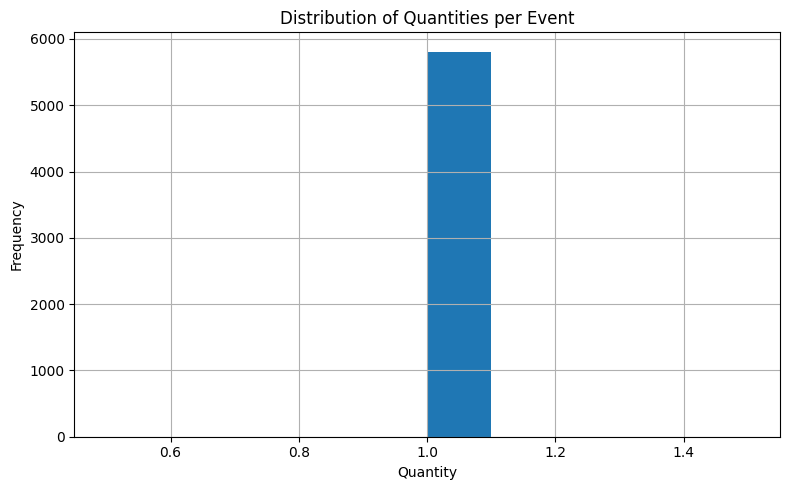

In [12]:
# ===== Cell 3: Quantity distribution (quantity_distribution.png) =====

plt.figure()
df["quantity"].dropna().hist(bins=10)
plt.title("Distribution of Quantities per Event")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("quantity_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


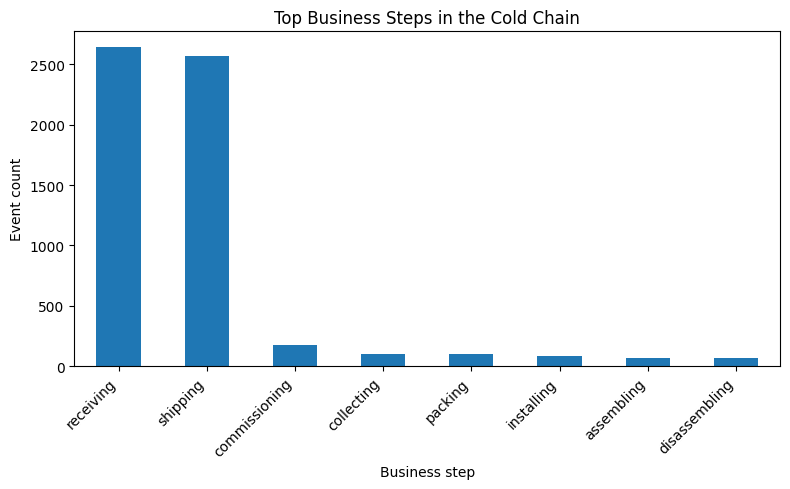

In [14]:

plt.figure()
df["biz_step"].value_counts().plot(kind="bar")
plt.title("Top Business Steps in the Cold Chain")
plt.xlabel("Business step")
plt.ylabel("Event count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("biz_steps.png", dpi=300, bbox_inches="tight")
plt.show()


In [15]:
# ===== Cell 5: Build chain-level features table 'agg' =====

# Sort for consistent first/last calculations
df = df.sort_values(["epc_class", "event_time"]).reset_index(drop=True)

agg = df.groupby("epc_class").agg(
    start_time=("event_time", "min"),
    end_time=("event_time", "max"),
    n_events=("event_time", "count"),
    n_locations=("biz_location_id", pd.Series.nunique),
    n_biz_steps=("biz_step", pd.Series.nunique)
).reset_index()

agg["chain_duration_hours"] = (
    agg["end_time"] - agg["start_time"]
).dt.total_seconds() / 3600.0

first_last = (
    df.groupby("epc_class")
      .agg(
          first_location=("biz_location_id", "first"),
          last_location=("biz_location_id", "last"),
          first_biz_step=("biz_step", "first"),
          last_biz_step=("biz_step", "last"),
      )
      .reset_index()
)

agg = agg.merge(first_last, on="epc_class", how="left")

# One-hot encode biz_step counts
biz_step_dummies = pd.get_dummies(df[["epc_class", "biz_step"]],
                                  columns=["biz_step"], prefix="bs")
biz_step_counts = biz_step_dummies.groupby("epc_class").sum().reset_index()

agg = agg.merge(biz_step_counts, on="epc_class", how="left")

print("Chain-level table shape:", agg.shape)
agg.head()


Chain-level table shape: (305, 19)


,epc_class,start_time,end_time,n_events,n_locations,n_biz_steps,chain_duration_hours,first_location,last_location,first_biz_step,last_biz_step,bs_assembling,bs_collecting,bs_commissioning,bs_disassembling,bs_installing,bs_packing,bs_receiving,bs_shipping
0,https://id.gs1.org/01/04011656840304/10/87881,2024-01-01 15:10:31+00:00,2024-02-29 05:14:00+00:00,13,6,5,1406.058056,https://id.gs1.org/414/0012738136579/254/30747,https://id.gs1.org/414/0012638246903/254/27956,collecting,receiving,0,1,1,0,0,1,5,5
1,https://id.gs1.org/01/04011850934472/10/15813,2024-02-20 10:32:16+00:00,2024-03-06 16:02:18+00:00,3,2,3,365.500556,https://id.gs1.org/414/0012638246903/254/27956,https://id.gs1.org/414/0012980685559/254/03120,shipping,commissioning,0,0,1,0,0,0,1,1
2,https://id.gs1.org/01/04011949795878/10/61085,2024-03-06 13:53:46+00:00,2024-06-18 17:48:57+00:00,24,11,3,2499.919722,https://id.gs1.org/414/0012627812768/254/31138,https://id.gs1.org/414/0012808525906/254/86778,commissioning,commissioning,0,0,2,0,0,0,11,11
3,https://id.gs1.org/01/04012111304843/10/65236,2024-01-01 12:37:11+00:00,2024-02-15 21:11:56+00:00,14,6,7,1088.579167,https://id.gs1.org/414/0012639282917/254/78160,https://id.gs1.org/414/0012958234833/254/46197,collecting,installing,1,1,0,1,1,1,5,4
4,https://id.gs1.org/01/04012428077508/10/19425,2024-01-01 17:50:48+00:00,2024-03-25 13:14:09+00:00,12,5,7,2011.389167,https://id.gs1.org/414/0012186781727/254/73165,https://id.gs1.org/414/0012531907710/254/66851,collecting,receiving,1,1,0,1,1,1,4,3


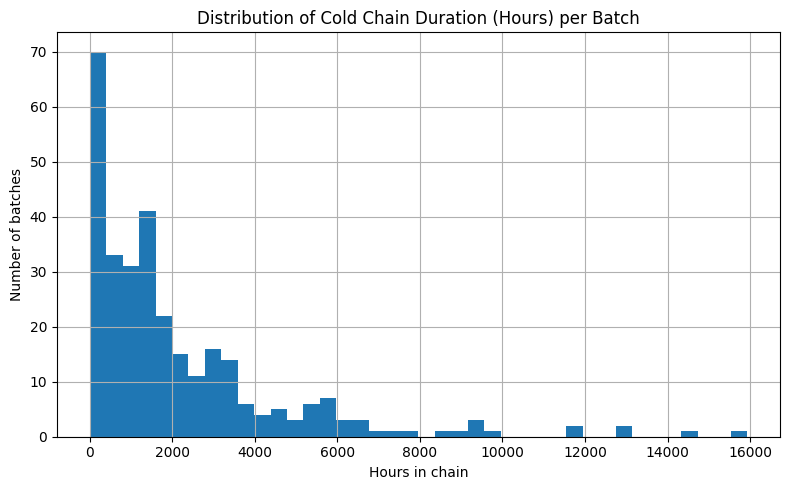

In [17]:
# ===== Cell 6: Duration distribution (duration_distribution.png) =====

plt.figure()
agg["chain_duration_hours"].hist(bins=40)
plt.title("Distribution of Cold Chain Duration (Hours) per Batch")
plt.xlabel("Hours in chain")
plt.ylabel("Number of batches")
plt.tight_layout()
plt.savefig("duration_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


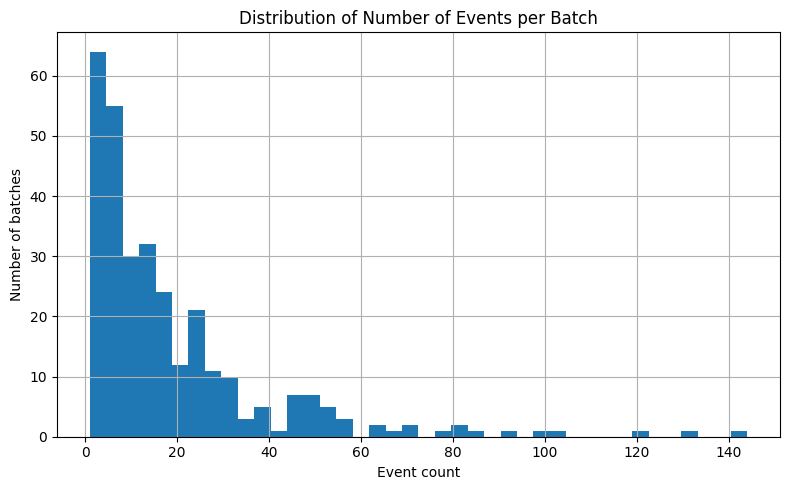

In [18]:


plt.figure()
agg["n_events"].hist(bins=40)
plt.title("Distribution of Number of Events per Batch")
plt.xlabel("Event count")
plt.ylabel("Number of batches")
plt.tight_layout()
plt.savefig("events_per_batch.png", dpi=300, bbox_inches="tight")
plt.show()


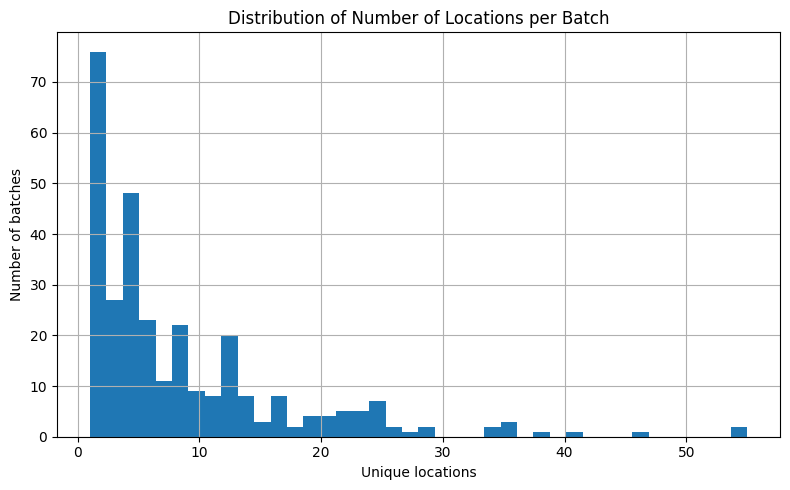

In [19]:

plt.figure()
agg["n_locations"].hist(bins=40)
plt.title("Distribution of Number of Locations per Batch")
plt.xlabel("Unique locations")
plt.ylabel("Number of batches")
plt.tight_layout()
plt.savefig("locations_per_batch.png", dpi=300, bbox_inches="tight")
plt.show()


75th percentile of duration (hours): 2915.0822222222223
long_chain
0    229
1     76
Name: count, dtype: int64
Feature matrix shape: (305, 16)
Train size: (244, 16) Test size: (61, 16)
Logistic Regression performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        46
           1       0.93      0.93      0.93        15

    accuracy                           0.97        61
   macro avg       0.96      0.96      0.96        61
weighted avg       0.97      0.97      0.97        61

ROC AUC: 0.9855072463768115


<Figure size 500x500 with 0 Axes>

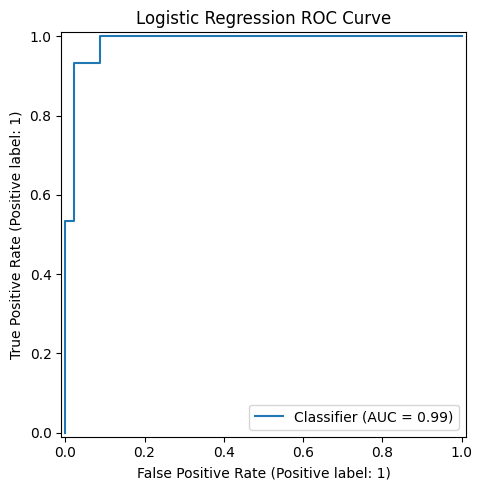

In [21]:
# ===== Cell 9: Prepare features X, label y, train/test split =====

# Define long_chain target as top 25% of duration
q75 = agg["chain_duration_hours"].quantile(0.75)
agg["long_chain"] = (agg["chain_duration_hours"] > q75).astype(int)
print("75th percentile of duration (hours):", q75)
print(agg["long_chain"].value_counts())

# Numeric feature columns
num_cols = ["n_events", "n_locations", "n_biz_steps"]
bs_cols = [c for c in agg.columns if c.startswith("bs_")]
num_cols = num_cols + bs_cols

# Categorical: first_location (top K only)
top_k = 5
top_first_locs = agg["first_location"].value_counts().head(top_k).index.tolist()
agg["first_location_top"] = agg["first_location"].where(
    agg["first_location"].isin(top_first_locs),
    other="OTHER"
)

X_num = agg[num_cols].fillna(0)
X_cat = pd.get_dummies(agg[["first_location_top"]], drop_first=True)

X = pd.concat([X_num, X_cat], axis=1)
y = agg["long_chain"]

print("Feature matrix shape:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
# ===== Cell 10: Logistic Regression + ROC curve (roc_logreg.png) =====

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression performance:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

plt.figure(figsize=(5, 5))
RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Logistic Regression ROC Curve")
plt.tight_layout()
plt.savefig("roc_logreg.png", dpi=300, bbox_inches="tight")
plt.show()


Random Forest performance:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        46
           1       0.81      0.87      0.84        15

    accuracy                           0.92        61
   macro avg       0.88      0.90      0.89        61
weighted avg       0.92      0.92      0.92        61

ROC AUC: 0.9637681159420289


<Figure size 500x500 with 0 Axes>

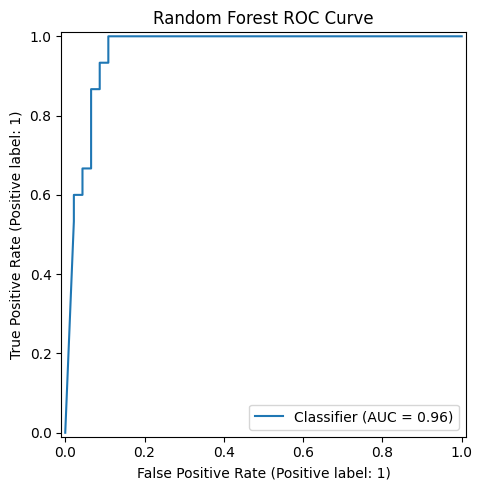

In [22]:
# ===== Cell 11: Random Forest + ROC curve (roc_rf.png) =====

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

plt.figure(figsize=(5, 5))
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest ROC Curve")
plt.tight_layout()
plt.savefig("roc_rf.png", dpi=300, bbox_inches="tight")
plt.show()


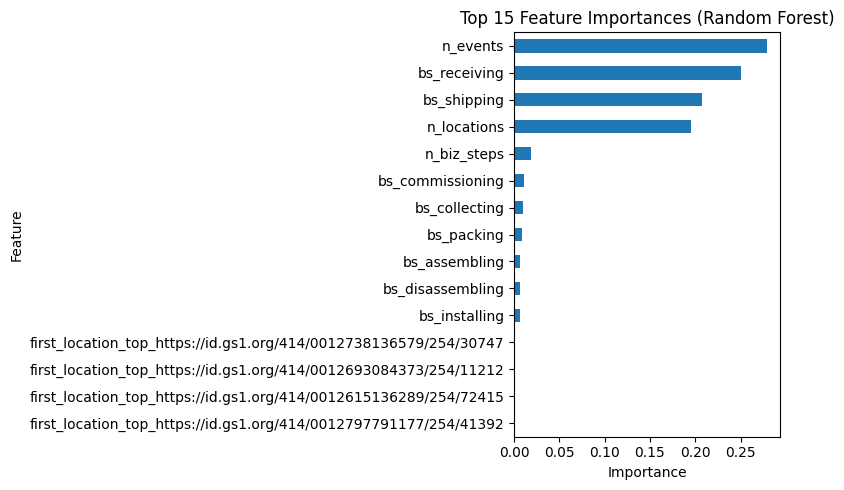

In [23]:
# ===== Cell 12: Random Forest feature importance (rf_feature_importance.png) =====

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 5))
importances_sorted.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("rf_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()


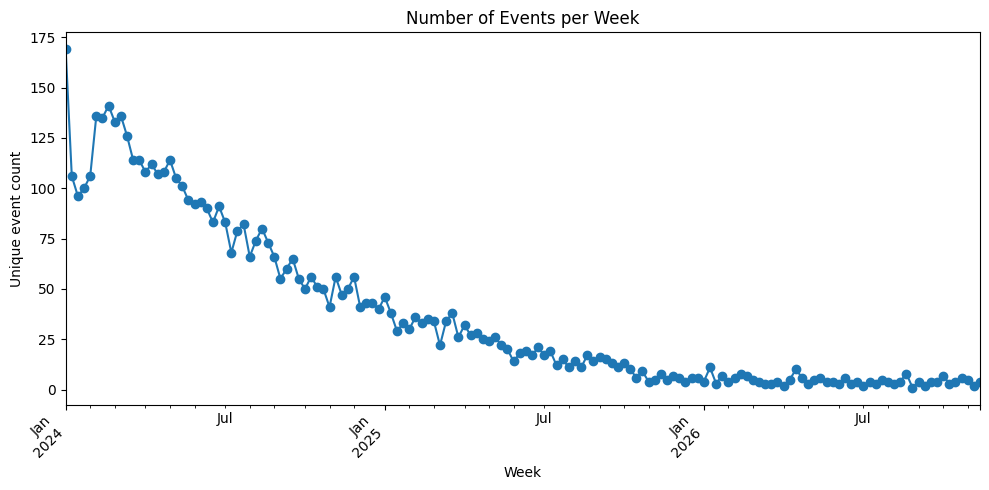

In [26]:

df["event_time"] = pd.to_datetime(df["event_time"])

df_weekly = (
    df.set_index("event_time")
      .resample("W")["event_id"]
      .nunique()
      .rename("events_per_week")
)

plt.figure(figsize=(10, 5))
df_weekly.plot(marker="o", linewidth=1.5)
plt.title("Number of Events per Week")
plt.xlabel("Week")
plt.ylabel("Unique event count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("events_per_day.png", dpi=300, bbox_inches="tight")
plt.show()


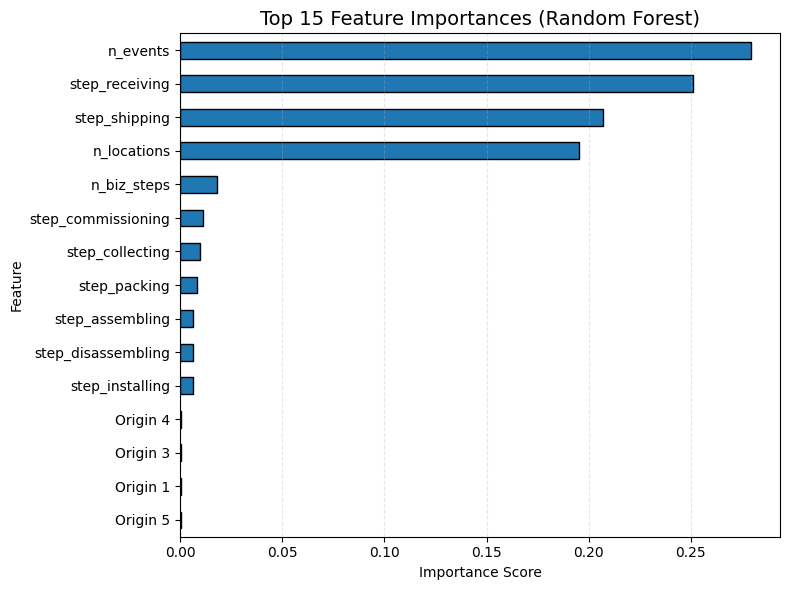

In [31]:
# ===== Clean feature name mapping (run before plotting importance) =====

clean_feature_names = {}

# 1) Map origin dummy variables to Origin 1, Origin 2, ...
origin_cols = [c for c in X.columns if c.startswith("first_location_top_")]
origin_cols_sorted = sorted(origin_cols)

origin_label_map = {}
for i, col in enumerate(origin_cols_sorted, start=1):
    origin_label_map[col] = f"Origin {i}"

# 2) Build clean_feature_names dict
for col in X.columns:
    if col in origin_label_map:
        clean_feature_names[col] = origin_label_map[col]
    elif col.startswith("bs_"):
        # business step dummy -> e.g. bs_shipping -> step_shipping
        clean_feature_names[col] = col.replace("bs_", "step_")
    else:
        # keep everything else as-is (n_events, n_locations, etc.)
        clean_feature_names[col] = col

# Sanity check
list(clean_feature_names.items())[:10]
# ===== Clean Random Forest feature importance plot (rf_feature_importance.png) =====

importances = pd.Series(rf.feature_importances_, index=X.columns)

# Take top 15 most important features
top_features = importances.sort_values(ascending=False).head(15)

# Apply clean labels for plotting
display_index = [clean_feature_names[col] for col in top_features.index]

plt.figure(figsize=(8, 6))
# Sort ascending so the biggest bar is at the top visually
top_features_sorted = pd.Series(top_features.values, index=display_index).sort_values()

top_features_sorted.plot(kind="barh", edgecolor="black")
plt.title("Top 15 Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("rf_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

